# **Project NLP Google news category analysis <br>YING SU**

### About Dataset<br>
https://www.kaggle.com/datasets/crxxom/daily-google-news<br>
This dataset contains metadata of millions of news articles from Google News, including title, publisher, DateTime, link, and category.<br>
<br>
This is also an automation project in which data is scraped every day at 4am UTC on 8 major categories. This dataset is expected to have a monthly update, thus the data collected daily will be merged into a single monthly csv file and published on Kaggle at the end of each month. One may expect the value of the dataset to continuously grow through time.<br>
<br>
What does the dataset contain?<br>
<br>
As mentioned, each monthly csv file mainly contain 5 columns<br>

1. Title:<br>
The title of the news article
<br>
2. Publisher:<br>
The publisher of the news article
<br>
3. DateTime:<br>
The DateTime of when the news article is published on Google News
<br>
4. Link:<br>
A link that will direct users to the corresponding article, one may feel free to dig deeper and scrape extended content by following the links
<br>
5. Category:<br>
8 major categories defined by Google News, particularly Business, Entertainment, Headlines, Health, Science, Sports, Technology and WorldWide.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # regular expressions => string parsing and filtering
import nltk # natural language toolkit => classification, tokenization, stemming, ...
import spacy # tokenizer, tagger, parser, NER, pretrained models
import string
pd.options.mode.chained_assignment = None

In [47]:
import plotly.express as px
import seaborn as sns

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier


In [49]:
from nltk.corpus import wordnet


## **Part 1 Data Exploration/ Data Preprocessing/ EDA**

In [50]:
data_raw = pd.read_csv("../Data/2023_9.csv", sep=",", encoding='utf-8')
print(f"Shape: {data_raw.shape}")

Shape: (51302, 5)


In [51]:
data_raw.head()

,Title,Publisher,DateTime,Link,Category
0,"Chainlink (LINK) Falters, Hedera (HBAR) Wobble...",Analytics Insight,2023-08-30T06:54:49Z,https://news.google.com/articles/CBMibGh0dHBzO...,Business
1,Funds punished for owning too few Nvidia share...,ZAWYA,2023-08-30T07:15:59Z,https://news.google.com/articles/CBMigwFodHRwc...,Business
2,Crude oil prices stalled as hedge funds sold: ...,ZAWYA,2023-08-30T07:31:31Z,https://news.google.com/articles/CBMibGh0dHBzO...,Business
3,Grayscale's Bitcoin Win Is Still Only Half the...,Bloomberg,2023-08-30T10:38:40Z,https://news.google.com/articles/CBMib2h0dHBzO...,Business
4,"I'm a Home Shopping Editor, and These Are the ...",Better Homes & Gardens,2023-08-30T11:00:00Z,https://news.google.com/articles/CBMiPWh0dHBzO...,Business


### Let's see if there is missing data

In [52]:
missing_data = data_raw.isnull().sum()
print(missing_data)

Title        0
Publisher    0
DateTime     0
Link         0
Category     0
dtype: int64


### Les's see if there are some duplicates

In [53]:
duplicate = data_raw.columns[data_raw.columns.duplicated()]
print(duplicate)

Index([], dtype='object')


    so far so good, do some analysis

In [54]:
# Remove the comma from the 'Title' column
data_raw['Title'] = data_raw['Title'].str.replace(',','')
# Remove brackets from the 'Title' column
data_raw['Title'] = data_raw['Title'].str.replace('(', '').str.replace(')', '')
print(data_raw.head())

                                               Title               Publisher  \
0  Chainlink LINK Falters Hedera HBAR Wobbles Yet...       Analytics Insight   
1  Funds punished for owning too few Nvidia share...                   ZAWYA   
2  Crude oil prices stalled as hedge funds sold: ...                   ZAWYA   
3  Grayscale's Bitcoin Win Is Still Only Half the...               Bloomberg   
4  I'm a Home Shopping Editor and These Are the C...  Better Homes & Gardens   

               DateTime                                               Link  \
0  2023-08-30T06:54:49Z  https://news.google.com/articles/CBMibGh0dHBzO...   
1  2023-08-30T07:15:59Z  https://news.google.com/articles/CBMigwFodHRwc...   
2  2023-08-30T07:31:31Z  https://news.google.com/articles/CBMibGh0dHBzO...   
3  2023-08-30T10:38:40Z  https://news.google.com/articles/CBMib2h0dHBzO...   
4  2023-08-30T11:00:00Z  https://news.google.com/articles/CBMiPWh0dHBzO...   

   Category  
0  Business  
1  Business  
2  Busin

In [93]:
data_raw['Title'].str.split(' ').apply(len)

0        12
1        12
2         9
3         9
4        15
         ..
51297    10
51298    11
51299    13
51300    11
51301    12
Name: Title, Length: 51302, dtype: int64

In [55]:
# do some analysis from each of the row 
data_raw['Title_len'] = data_raw['Title'].str.split(' ').apply(len)
print(data_raw['Title_len'].describe())

count    51302.000000
mean        11.620989
std          3.452582
min          1.000000
25%          9.000000
50%         11.000000
75%         14.000000
max         42.000000
Name: Title_len, dtype: float64


In [56]:
# a another way to it
data_raw['Title_len'] = data_raw['Title'].apply(lambda x: len(x.split(' ')))
print(data_raw['Title_len'].describe())

count    51302.000000
mean        11.620989
std          3.452582
min          1.000000
25%          9.000000
50%         11.000000
75%         14.000000
max         42.000000
Name: Title_len, dtype: float64


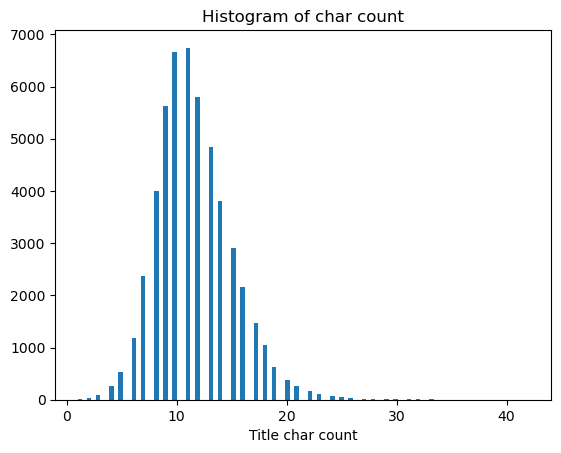

In [57]:
plt.hist(data_raw['Title_len'], bins=100)
plt.xlabel('Title char count')
plt.title("Histogram of char count")
plt.show()

Most of Title length are round 8 to 14

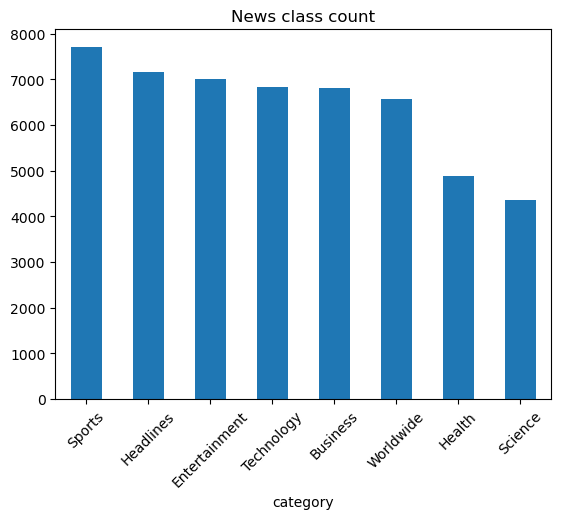

In [58]:
data_raw['Category'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('News class count')
plt.xlabel("category")
plt.show()


We can see that for the Class(Health and Science), there are less than others.

### Caculate the median length title of each class 

In [59]:
median_lengths = data_raw.groupby('Category')['Title'].apply(lambda x: x.str.len().median())

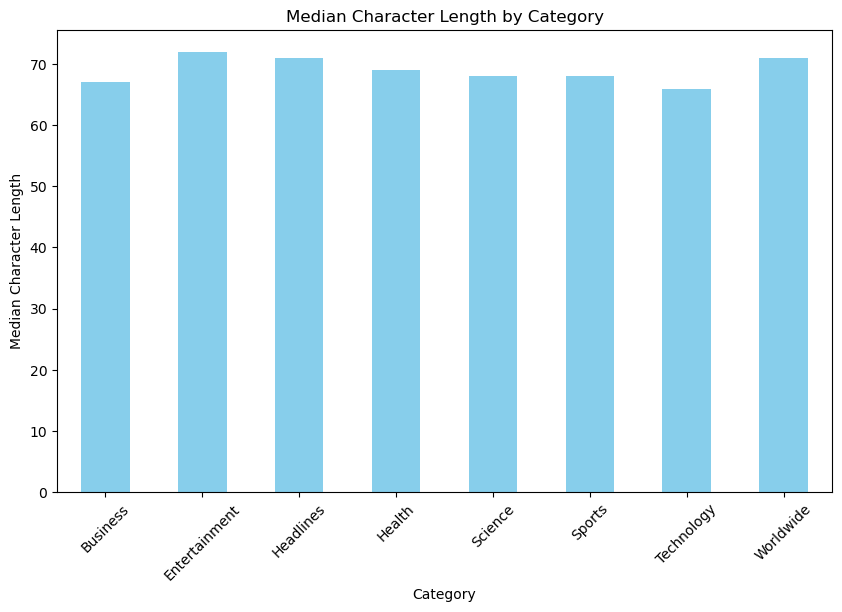

In [60]:
plt.figure(figsize=(10, 6))
median_lengths.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Median Character Length')
plt.title('Median Character Length by Category')
plt.xticks(rotation=45)
plt.show()

### With this graph, we can see that the length is not important for trainning. This variable we can throw away :)

### Character Count by Category(Scatter plot)

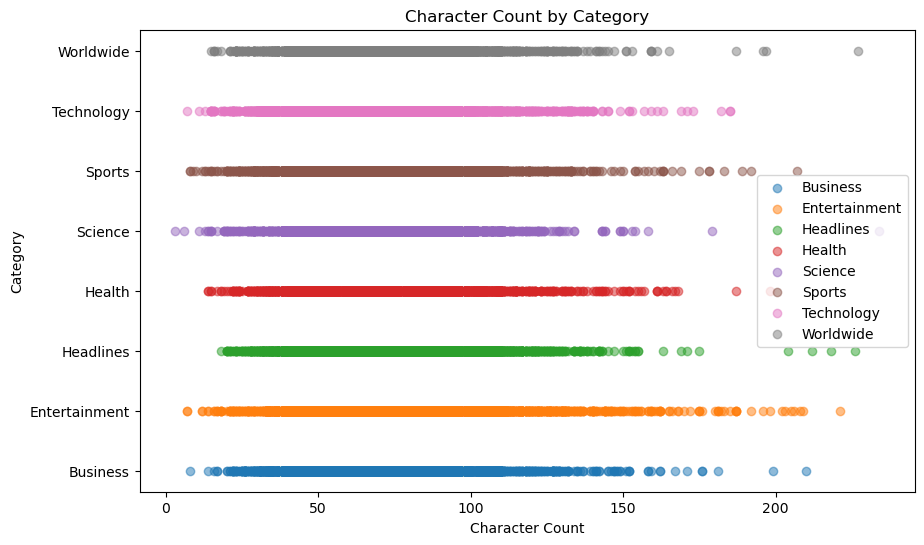

In [61]:
data_raw['Character Count'] = data_raw['Title'].str.len()


plt.figure(figsize=(10, 6))
for category, group in data_raw.groupby('Category'):
    plt.scatter(group['Character Count'], [category] * len(group), label=category, alpha=0.5)

plt.xlabel('Character Count')
plt.ylabel('Category')
plt.title('Character Count by Category')
plt.legend()
plt.show()

## **PREPROCESSING**

In [62]:
text_df = data_raw[["Title"]]

In [63]:
print("Before lowering:")
print(text_df.head().Title.values)

Before lowering:
['Chainlink LINK Falters Hedera HBAR Wobbles Yet VC Spectra SPCT Stands Tall!'
 'Funds punished for owning too few Nvidia shares after stunning 230% rally'
 'Crude oil prices stalled as hedge funds sold: Kemp'
 "Grayscale's Bitcoin Win Is Still Only Half the Battle"
 "I'm a Home Shopping Editor and These Are the Can't-Miss Labor Day Deals I'm Eyeing"]


In [64]:
# Convert the text_df text column to lowercase
text_df["Title"] = text_df["Title"].str.lower()

In [65]:
print("After lowering:")
print(text_df.head().Title.values)
text_df.head()

After lowering:
['chainlink link falters hedera hbar wobbles yet vc spectra spct stands tall!'
 'funds punished for owning too few nvidia shares after stunning 230% rally'
 'crude oil prices stalled as hedge funds sold: kemp'
 "grayscale's bitcoin win is still only half the battle"
 "i'm a home shopping editor and these are the can't-miss labor day deals i'm eyeing"]


,Title
0,chainlink link falters hedera hbar wobbles yet...
1,funds punished for owning too few nvidia share...
2,crude oil prices stalled as hedge funds sold: ...
3,grayscale's bitcoin win is still only half the...
4,i'm a home shopping editor and these are the c...


Converting Text to Lowercase: The reason for converting text to lowercase is to standardize the text so that case differences do not lead to inconsistencies in subsequent processing. This helps reduce vocabulary diversity and makes the text easier to handle.

## **Removal of Punctuations**

In [66]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text: str) -> str:
    
    translation_table = str.maketrans('','',PUNCT_TO_REMOVE)
    return text.translate(translation_table)
text_df["Title"] = text_df["Title"].apply(remove_punctuation)

In [67]:
text_df.head()

,Title
0,chainlink link falters hedera hbar wobbles yet...
1,funds punished for owning too few nvidia share...
2,crude oil prices stalled as hedge funds sold kemp
3,grayscales bitcoin win is still only half the ...
4,im a home shopping editor and these are the ca...


Removing Punctuation: Punctuation marks typically do not contain much information, so removing them helps the text processing to focus on words. This step reduces the dimensionality of the text and enhances processing efficiency.

## **Removal of stopwords**

In [68]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suying/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
def remove_stopwords(text: str) -> str:
    """
    Removes stopwords from the input text

    Args: 
        text (str): The input text from which stopwords will be removed

    Returns:
        str: A new string without stopwords
    """
   
    
    # Split the input text into a list of words
    words = text.split()

    # Remove stopwords from the list of words
    filtered_words = [word for word in words if word.lower() not in stopwords]

    # Join the filtered words back into a single string
    result_text = " ".join(filtered_words)

    return result_text
   
   

text_df["Title"] = text_df["Title"].apply(remove_stopwords)
text_df.head()

,Title
0,chainlink link falters hedera hbar wobbles yet...
1,funds punished owning nvidia shares stunning 2...
2,crude oil prices stalled hedge funds sold kemp
3,grayscales bitcoin win still half battle
4,im home shopping editor cantmiss labor day dea...


Removing Stopwords: Stopwords are common words that usually do not carry important information, such as "a," "an," "the," and so on. Removing these words reduces the dimensionality of the text and enhances model efficiency. In this step, you used a stopwords list provided by the NLTK library.

## **Stemming**

In [70]:
from nltk.stem.porter import PorterStemmer

def stem_words(text: str) -> str:
    """
    Applies the stemmer to an input string

    Args: 
        text (str): The text to be stemmed

    Returns:
        str: A new string where every word has been stemmed
    """
    # return a string where each word has been stemmed
     # Create a Porter Stemmer object
    stemmer = PorterStemmer()

    # Split the input text into words
    words = text.split()

    # Apply stemming to each word and store the stemmed words in a list
    stemmed_words = [stemmer.stem(word) for word in words]

    # Join the stemmed words back into a single string
    result_text = " ".join(stemmed_words)

    return result_text
    

In [71]:
text_df["Title"] = text_df["Title"].apply(stem_words)
text_df.head()

,Title
0,chainlink link falter hedera hbar wobbl yet vc...
1,fund punish own nvidia share stun 230 ralli
2,crude oil price stall hedg fund sold kemp
3,grayscal bitcoin win still half battl
4,im home shop editor cantmiss labor day deal im...


Stemming: Stemming is the process of reducing words to their basic form, such as converting plural forms or derived forms of words to their original stems. This helps reduce vocabulary diversity, decrease dimensionality, and improve model efficiency. In your example, you used the Porter stemming algorithm.

## **Lemmatization**

In [72]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/suying/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [73]:
lemmatizer = WordNetLemmatizer()

In [74]:
def lemmatize_words(text: str) -> str:

    wordnet_map = {
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV,
        'J': wordnet.ADJ
    }
    pos_tagged_text = nltk.pos_tag(nltk.word_tokenize(text))
    lemmatized_pos_tagged_text = [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]
    return ' '.join(lemmatized_pos_tagged_text)

In [75]:
text_df["Title"] = text_df["Title"].apply(lemmatize_words)
text_df.head()

,Title
0,chainlink link falter hedera hbar wobbl yet vc...
1,fund punish own nvidia share stun 230 ralli
2,crude oil price stall hedg fund sell kemp
3,grayscal bitcoin win still half battl
4,im home shop editor cantmiss labor day deal im...


Lemmatization: Unlike stemming, lemmatization aims to return words to their original forms in the language. This can better preserve the semantics of words. In your example, you applied lemmatization using an undefined lemmatizer. Please make sure to define the lemmatizer in your code.

### Why you use specific functions in a particular order？

This sequence and the choice of these steps are logical because they gradually extract useful information from the text while reducing dimensionality and enhancing processing efficiency. Depending on the specific NLP task, you can optionally include or exclude these steps to meet the task's requirements. Also, make sure to define the lemmatizer when using lemmatization in your code

### Now, we create a new dataframe called df (concat two columns)

In [76]:
columns_to_merge = [text_df, data_raw["Category"]]
df = pd.concat(columns_to_merge, axis=1)
df.columns = ["Title", "Category"]
df

,Title,Category
0,chainlink link falter hedera hbar wobbl yet vc...,Business
1,fund punish own nvidia share stun 230 ralli,Business
2,crude oil price stall hedg fund sell kemp,Business
3,grayscal bitcoin win still half battl,Business
4,im home shop editor cantmiss labor day deal im...,Business
...,...,...
51297,slovakia elect could echo ukrain here expect,Worldwide
51298,thing know nobel prize washington post,Worldwide
51299,brief calm protest kill 2 student rock imphal,Worldwide
51300,‘ no one safe ’ franc vow action bedbug sweep ...,Worldwide


In [77]:
class_distribution = df['Category'].value_counts()
print(class_distribution)

Category
Sports           7709
Headlines        7155
Entertainment    7003
Technology       6822
Business         6800
Worldwide        6575
Health           4877
Science          4361
Name: count, dtype: int64


In [78]:
category_counts = df['Category'].value_counts().index.tolist()

In [79]:
category_orders = {"Category": category_counts}
fig = px.histogram(df, x='Category', category_orders= category_orders)
fig.show()

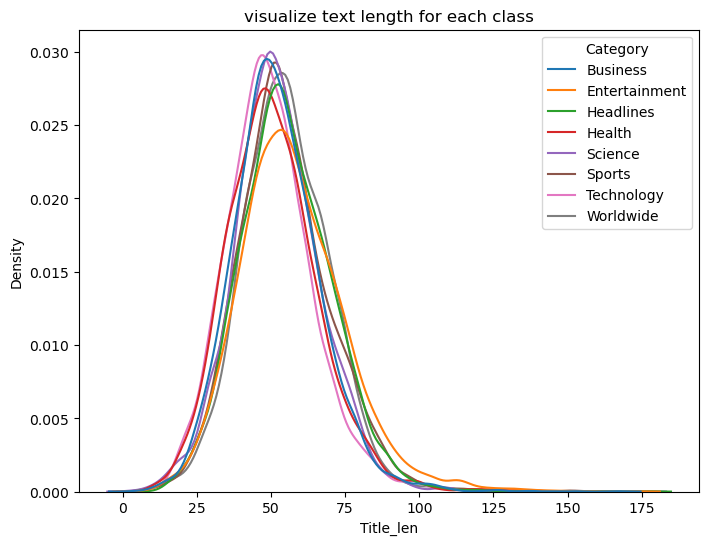

In [80]:
df['Title_len'] = df['Title'].apply(len)
plt.figure(figsize=(8,6))

# use the sns.kdeplot function to visualize text length for each class # https://seaborn.pydata.org/generated/seaborn.kdeplot.html
sns.kdeplot(data=df, x='Title_len', hue='Category', common_norm=False)


plt.title("visualize text length for each class")
plt.show()

In [81]:
#df.groupby('Category').apply(len).describe()
category_descriptions = df.groupby('Category').apply(lambda x: x.describe())
print(category_descriptions)

                   Title_len
Category                    
Business  count  6800.000000
          mean     51.901029
          std      14.889900
          min       3.000000
          25%      42.000000
...                      ...
Worldwide min       3.000000
          25%      45.000000
          50%      55.000000
          75%      65.000000
          max     159.000000

[64 rows x 1 columns]


In [82]:
df.shape

(51302, 3)

In [83]:
df.dtypes

Title        object
Category     object
Title_len     int64
dtype: object

In [87]:
df.drop('Title_len',axis=1,inplace= True)

In [91]:
df.to_csv('../Data/clean_data.csv',index = False)

##  **Part2 Machine Learning**

    1)Count Vectors + MultinomialNB()


In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score

    Feature Fngineering(CountVectorizer)

In [36]:
vectorizer = CountVectorizer()
train_test = vectorizer.fit_transform(df['Title'])

In [37]:
bag_of_words_df = pd.DataFrame(train_test.toarray())# convert the processed vectors to arrays (look at the "examples" section in the docs) and create a dataframe based on those vectors
bag_of_words_df

,0,1,2,3,4,5,6,7,8,9,...,25800,25801,25802,25803,25804,25805,25806,25807,25808,25809
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51298,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51299,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df.head()

,Title,Category,Title_len
0,chainlink link falter hedera hbar wobbl yet vc...,Business,71
1,fund punish own nvidia share stun 230 ralli,Business,43
2,crude oil price stall hedg fund sold kemp,Business,41
3,grayscal bitcoin win still half battl,Business,37
4,im home shop editor cantmiss labor day deal im...,Business,50


In [39]:
label_encoder = LabelEncoder()# instantiate a label encoder # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
df['Category_enc'] = label_encoder.fit_transform(df['Category'])# fit and transform the encoder on labels

In [40]:
# Split the data into training and testing sets
X =bag_of_words_df  #  Assuming 'OriginalTweet' is your feature
y = df['Category_enc']#  Assuming 'Sentiment_enc' is your encoded target label

test_size=0.2
random_state=42

# use the train_test_split function with the above test size and random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) 


    Model(MultinomialNB)

In [41]:
clf1 = MultinomialNB()
clf1.fit(X_train,y_train)

MultinomialNB()

    F1_Score(MultinomialNB)

In [42]:

val_pred1 = clf1.predict(X_test)
print(f1_score(y_test, val_pred1, average='macro'))
 

0.8673575142179051


## ***Results visualization***

In [46]:
# styling the confusion matrix
confusion_matrix_kwargs = dict(
    text_auto=True,
    title="Confusion Matrix", width=1000, height=800,
    labels=dict(x="Predicted", y="True Label"),
    x=class_labels,
    y=class_labels,
    color_continuous_scale='Blues'
)

def report(y_true, y_pred, class_labels):
    print(classification_report(y_true, y_pred, target_names=class_labels))
    # print a classification report of the predictions # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn-metrics-classification-report
    # create a confusion matrix and pass it to imshow to visualize it # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
    # (the confusion_matrix_kwargs are here for styling only)
    conf_matrix = confusion_matrix(y_true, y_pred)
    fig = px.imshow(
        conf_matrix,
        **confusion_matrix_kwargs
        )
    fig.show()

In [47]:
class_labels = label_encoder.inverse_transform(range(8))
# call the report function to visualize the classification results, use the above class_labels
report(y_test, val_pred1, class_labels)

               precision    recall  f1-score   support

     Business       0.87      0.82      0.84      1380
Entertainment       0.91      0.92      0.91      1384
    Headlines       0.76      0.66      0.71      1420
       Health       0.89      0.94      0.91       943
      Science       0.89      0.93      0.91       902
       Sports       0.94      0.95      0.95      1592
   Technology       0.93      0.94      0.93      1351
    Worldwide       0.74      0.81      0.77      1289

     accuracy                           0.87     10261
    macro avg       0.87      0.87      0.87     10261
 weighted avg       0.87      0.87      0.87     10261



    We can see that the result is good,but there are some problems like worldwide and headlines, the model can not idenfity well.

### Let's try another Way to build a now model with new feature engineering(TF-IDF)

    2)TF-IDF + MultinomialNB

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score


In [112]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=30000)
train_test = tfidf.fit_transform(df['Title'])


In [113]:
# Split the data into training and testing sets
X =train_test  #  Assuming 'OriginalTweet' is your feature
y = df['Category_enc']#  Assuming 'Sentiment_enc' is your encoded target label

test_size=0.2
random_state=42

# use the train_test_split function with the above test size and random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split


In [114]:
clf2 = MultinomialNB()
clf2.fit(X_train,y_train)

MultinomialNB()

    F1_Score(MultinomialNB)

In [115]:
val_pred2 = clf2.predict(X_test)
print(f1_score(y_test, val_pred2, average='macro'))

0.8711035394753813


In [116]:
class_labels = label_encoder.inverse_transform(range(8))
# call the report function to visualize the classification results, use the above class_labels
report(y_test, val_pred2, class_labels)

               precision    recall  f1-score   support

     Business       0.86      0.85      0.85      1380
Entertainment       0.91      0.93      0.92      1384
    Headlines       0.76      0.66      0.71      1420
       Health       0.90      0.93      0.92       943
      Science       0.94      0.88      0.91       902
       Sports       0.94      0.97      0.95      1592
   Technology       0.93      0.95      0.94      1351
    Worldwide       0.73      0.81      0.77      1289

     accuracy                           0.87     10261
    macro avg       0.87      0.87      0.87     10261
 weighted avg       0.87      0.87      0.87     10261



### Now this is a simple conclusion that TF-IDF is better than CountVectorizer,so i will change the parameter like(ngram_range, max_features)

    3)TF-IDF2 + MultinomialNB

In [117]:
tfidf = TfidfVectorizer(ngram_range=(1, 6), max_features=30000)
train_test = tfidf.fit_transform(df['Title'])

In [118]:
# Split the data into training and testing sets
X =train_test  #  Assuming 'OriginalTweet' is your feature
y = df['Category_enc']#  Assuming 'Sentiment_enc' is your encoded target label

test_size=0.2
random_state=42

# use the train_test_split function with the above test size and random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split


In [119]:
clf3 = MultinomialNB()
clf3.fit(X_train,y_train)

MultinomialNB()

In [120]:
val_pred3 = clf3.predict(X_test)
print(f1_score(y_test, val_pred3, average='macro'))

0.8701939638607447


In [121]:
class_labels = label_encoder.inverse_transform(range(8))
# call the report function to visualize the classification results, use the above class_labels
report(y_test, val_pred3, class_labels)

               precision    recall  f1-score   support

     Business       0.86      0.85      0.85      1380
Entertainment       0.91      0.92      0.92      1384
    Headlines       0.76      0.66      0.71      1420
       Health       0.90      0.93      0.91       943
      Science       0.94      0.88      0.91       902
       Sports       0.94      0.97      0.95      1592
   Technology       0.93      0.95      0.94      1351
    Worldwide       0.73      0.81      0.77      1289

     accuracy                           0.87     10261
    macro avg       0.87      0.87      0.87     10261
 weighted avg       0.87      0.87      0.87     10261



    The conclusion is the parameter (ngram_range, max_features), don't change too much :)

### Now,change the model to ridgeclassifier

    4)TF-IDF + RidgeClassifier

In [122]:
clf4 = RidgeClassifier()
clf4.fit(X_train,y_train)

RidgeClassifier()

In [123]:
val_pred4 = clf4.predict(X_test)
print(f1_score(y_test, val_pred4, average='macro'))

0.8843443980348507


In [125]:
class_labels = label_encoder.inverse_transform(range(8))
# call the report function to visualize the classification results, use the above class_labels
report(y_test, val_pred4, class_labels)

               precision    recall  f1-score   support

     Business       0.88      0.87      0.88      1380
Entertainment       0.93      0.94      0.94      1384
    Headlines       0.77      0.67      0.72      1420
       Health       0.91      0.94      0.93       943
      Science       0.93      0.94      0.93       902
       Sports       0.96      0.97      0.97      1592
   Technology       0.96      0.96      0.96      1351
    Worldwide       0.73      0.79      0.76      1289

     accuracy                           0.88     10261
    macro avg       0.88      0.89      0.88     10261
 weighted avg       0.88      0.88      0.88     10261



### Looks like these models are good but these models above have all the same problem<br>

### They can not understand well the Worldwide and Headlines.<br>

### I have to think a way to fix this problem.

:):):):):)

### **NOW, We use the class weights to fix the problem**

To balance classes in an imbalanced dataset, we can consider using oversampling or subsampling methods to ensure that the model performs better on all classes. we can  apply class weights, which is particularly useful for imbalanced datasets.

In [126]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for each class
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary associating class labels with their corresponding weights
class_weight_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

# Create a classifier and set the class weights
clf5 = RidgeClassifier(class_weight=class_weight_dict)

# Train the model
clf5.fit(X_train, y_train)

# Make predictions
y_pred = clf5.predict(X_test)

val_pred5 = clf5.predict(X_test)
print("F1 Score:",f1_score(y_test, val_pred5, average='macro'))

class_labels = label_encoder.inverse_transform(range(8))
# call the report function to visualize the classification results, use the above class_labels
report(y_test, val_pred5, class_labels)

0.8844349521717376
               precision    recall  f1-score   support

     Business       0.89      0.87      0.88      1380
Entertainment       0.93      0.94      0.93      1384
    Headlines       0.78      0.66      0.72      1420
       Health       0.90      0.95      0.93       943
      Science       0.92      0.94      0.93       902
       Sports       0.96      0.97      0.97      1592
   Technology       0.96      0.95      0.96      1351
    Worldwide       0.73      0.81      0.77      1289

     accuracy                           0.88     10261
    macro avg       0.88      0.89      0.88     10261
 weighted avg       0.88      0.88      0.88     10261



    There is still the same error , Maybe try the RandomForestClassifier

In [127]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)


rf_classifier.fit(X_train, y_train)  

y_pred_rf = rf_classifier.predict(X_test) 

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_rf, average='macro')
print("F1 Score:", f1)


Accuracy: 0.8205827892018321
F1 Score: 0.8230485308877418


    The result is worse than before

In [130]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(confusion)


Confusion Matrix:
[[1103   23   77   43   11   46   35   42]
 [  37 1201   50   17   14   42   14    9]
 [  76   38  865   19   19   53    8  342]
 [  10   10   10  866   25   14    5    3]
 [   9    9   17   34  798    7   10   18]
 [  21   38   34    3    4 1481    6    5]
 [  29   30   12    9   15   14 1237    5]
 [  49   24  276   21   15   29    6  869]]


In [131]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_rf)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1380
           1       0.87      0.87      0.87      1384
           2       0.65      0.61      0.63      1420
           3       0.86      0.92      0.89       943
           4       0.89      0.88      0.89       902
           5       0.88      0.93      0.90      1592
           6       0.94      0.92      0.93      1351
           7       0.67      0.67      0.67      1289

    accuracy                           0.82     10261
   macro avg       0.82      0.82      0.82     10261
weighted avg       0.82      0.82      0.82     10261



    Let's look specifically at class (headline and worldwide)

In [146]:
pd.set_option('display.max_colwidth', None)
cunfusion_class = data_raw[data_raw['Category'] == 'Headlines']
cunfusion_class_Title = cunfusion_class['Title']
print(cunfusion_class_Title)

13803                                                                                    PBS NewsHour West live episode Aug. 29 2023
13804                                                                        Why let two people ban so many Florida books? | Letters
13805                                        Why did tourists keep coming as Rhodes and Maui burned? It’s about far more than denial
13806                                                          Opinion | There's plenty of blame to go around in the David Cole case
13807    First stapled visas and now bunkers tunnels near LAC: China's calculated attempt to challenge India's territorial integrity
                                                                    ...                                                             
20953                                         Special counsel notes Trump’s gun store visit and Milley remarks in push for gag order
20954                                                                

In [147]:
pd.set_option('display.max_colwidth', None)
cunfusion_class = data_raw[data_raw['Category'] == 'Worldwide']
cunfusion_class_Title = cunfusion_class['Title']
print(cunfusion_class_Title)

44727                                                                                                   A Tragic Fire and Broken Promises in South Africa
44728    Ukraine war latest: Poland summons ambassador over Zelenskyy comments; Moscow evacuates civilians after military operation launched by neighbour
44729                                                                                                            WATCH LIVE: Pentagon holds news briefing
44730                                                                     Japan talent agent Johnny Kitagawa sexually assaulted hundreds of teens: report
44731                                                                                     Group behind cyber attacks at local hospitals taken down by FBI
                                                                               ...                                                                       
51297                                                                       

### ***From above that we can see even humans are diffcult to identified the class Headlines and WorldWide.***

### **Maybe Let's try the Deep Learning that can fix this problem**

### **Part4 Deep Learning** <br>
### Word Embeddings with Word2Vec and TensorFlow

In [160]:
import logging
import random

import numpy as np
import torch

logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s')

# set seed
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)


# split data to 10 fold
fold_num = 10
data_file = '2023_9.csv'
import pandas as pd

train_set = pd.read_csv(data_file, sep=',', nrows=1000)
train_set

# data to fold
def all_data2fold(fold_num, num=10000):
    fold_data = []
    f = pd.read_csv(data_file, sep=',', encoding='UTF-8')
    texts = f['Title'].tolist()[:num]
    labels = f['Category'].tolist()[:num]

    total = len(labels)

    index = list(range(total))
    np.random.shuffle(index)

    all_texts = []
    all_labels = []
    for i in index:
        all_texts.append(texts[i])
        all_labels.append(labels[i])

    label2id = {}
    for i in range(total):
        label = str(all_labels[i])
        if label not in label2id:
            label2id[label] = [i]
        else:
            label2id[label].append(i)

    all_index = [[] for _ in range(fold_num)]
    for label, data in label2id.items():
        # print(label, len(data))
        batch_size = int(len(data) / fold_num)
        other = len(data) - batch_size * fold_num
        for i in range(fold_num):
            cur_batch_size = batch_size + 1 if i < other else batch_size
            # print(cur_batch_size)
            batch_data = [data[i * batch_size + b] for b in range(cur_batch_size)]
            all_index[i].extend(batch_data)

    batch_size = int(total / fold_num)
    other_texts = []
    other_labels = []
    other_num = 0
    start = 0

    for fold in range(fold_num):
        num = len(all_index[fold])
        texts = [all_texts[i] for i in all_index[fold]]
        labels = [all_labels[i] for i in all_index[fold]]

        if num > batch_size:
            fold_texts = texts[:batch_size]
            other_texts.extend(texts[batch_size:])
            fold_labels = labels[:batch_size]
            other_labels.extend(labels[batch_size:])
            other_num += num - batch_size
        elif num < batch_size:
            end = start + batch_size - num
            fold_texts = texts + other_texts[start: end]
            fold_labels = labels + other_labels[start: end]
            start = end
        else:
            fold_texts = texts
            fold_labels = labels

        assert batch_size == len(fold_labels)

        # shuffle
        index = list(range(batch_size))
        np.random.shuffle(index)

        shuffle_fold_texts = []
        shuffle_fold_labels = []
        for i in index:
            shuffle_fold_texts.append(fold_texts[i])
            shuffle_fold_labels.append(fold_labels[i])

        data = {'label': shuffle_fold_labels, 'text': shuffle_fold_texts}
        fold_data.append(data)

    logging.info("Fold lens %s", str([len(data['label']) for data in fold_data]))

    return fold_data


fold_data = all_data2fold(10)

# build train data for word2vec
fold_id = 9

train_texts = []
for i in range(0, fold_id):
    data = fold_data[i]
    train_texts.extend(data['text'])

logging.info('Total %d docs.' % len(train_texts))


logging.info('Start training...')
from gensim.models.word2vec import Word2Vec

num_features = 100     # Word vector dimensionality
num_workers = 8       # Number of threads to run in parallel

train_texts = list(map(lambda x: list(x.split()), train_texts))
model = Word2Vec(train_texts, workers=num_workers, vector_size=num_features)
model.init_sims(replace=True)

# save model
model.save("word2vec.bin")


# load model
model = Word2Vec.load("word2vec.bin")

# convert format
model.wv.save_word2vec_format('word2vec.txt', binary=False)


2023-11-05 18:44:24,439 INFO: Fold lens [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
2023-11-05 18:44:24,444 INFO: Total 9000 docs.
2023-11-05 18:44:24,445 INFO: Start training...
2023-11-05 18:44:24,451 INFO: collecting all words and their counts
2023-11-05 18:44:24,451 INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-11-05 18:44:24,462 INFO: collected 22464 word types from a corpus of 105290 raw words and 9000 sentences
2023-11-05 18:44:24,463 INFO: Creating a fresh vocabulary
2023-11-05 18:44:24,468 INFO: Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 3929 unique words (17.49% of original 22464, drops 18535)', 'datetime': '2023-11-05T18:44:24.468900', 'gensim': '4.3.2', 'python': '3.11.2 (main, Feb 16 2023, 02:55:59) [Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-14.0-arm64-i386-64bit', 'event': 'prepare_vocab'}
2023-11-05 18:44:24,469 INFO: Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 76608 wo

In [58]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

num_classes = 8

# Convert integer target labels to one-hot encoding
y_one_hot = to_categorical(df['Category_enc'], num_classes)

# Use Tokenizer to convert text into word embedding sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Title'])
X_sequences = tokenizer.texts_to_sequences(df['Title'])

# Pad sequences to have the same length
max_sequence_length = 100  # Specify the maximum sequence length
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

# Build the TextCNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

embedding_dim = 100 

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Split the dataset, a typical ratio could be 70-15-15, or adjust as needed
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/20
562/562 [==============================] - 8s 15ms/step - loss: 0.8444 - accuracy: 0.7133 - val_loss: 0.4418 - val_accuracy: 0.8416
Epoch 2/20
562/562 [==============================] - 8s 14ms/step - loss: 0.2491 - accuracy: 0.9153 - val_loss: 0.4100 - val_accuracy: 0.8671
Epoch 3/20
562/562 [==============================] - 8s 14ms/step - loss: 0.1400 - accuracy: 0.9494 - val_loss: 0.4404 - val_accuracy: 0.8547
Epoch 4/20
562/562 [==============================] - 8s 14ms/step - loss: 0.1042 - accuracy: 0.9595 - val_loss: 0.4718 - val_accuracy: 0.8561
Epoch 5/20
562/562 [==============================] - 8s 14ms/step - loss: 0.0876 - accuracy: 0.9632 - val_loss: 0.4994 - val_accuracy: 0.8524
Epoch 6/20
562/562 [==============================] - 8s 14ms/step - loss: 0.0774 - accuracy: 0.9656 - val_loss: 0.5401 - val_accuracy: 0.8552
Epoch 7/20
562/562 [==============================] - 8s 14ms/step - loss: 0.0709 - accuracy: 0.9661 - val_loss: 0.6010 - val_accuracy: 0.8520

In [59]:
max_sequence_length = max(len(seq) for seq in X_sequences)
print (max_sequence_length)

30


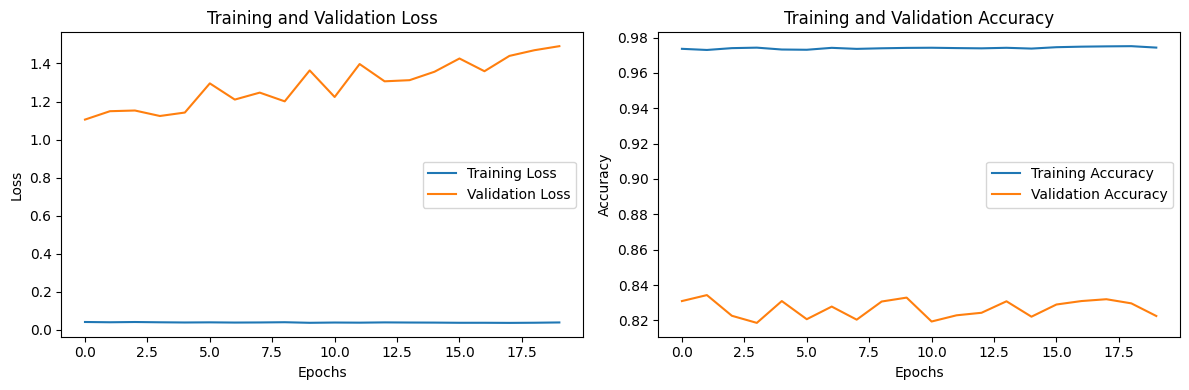

In [60]:
import matplotlib.pyplot as plt


history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=0)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()



We will also use a callback to log metrics for visualization with Tensorboard:

In [61]:
from tensorflow import keras

root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y.%m.%d_%H-%M-%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir
# callback creation
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

 ### Retrain model with callbacks

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
562/562 [==============================] - 9s 16ms/step - loss: 0.8422 - accuracy: 0.7169 - val_loss: 0.4321 - val_accuracy: 0.8576
Epoch 2/20
562/562 [==============================] - 9s 16ms/step - loss: 0.2482 - accuracy: 0.9162 - val_loss: 0.4209 - val_accuracy: 0.8606
Epoch 3/20
562/562 [==============================] - 9s 16ms/step - loss: 0.1444 - accuracy: 0.9471 - val_loss: 0.4452 - val_accuracy: 0.8603
Epoch 4/20
562/562 [==============================] - 9s 16ms/step - loss: 0.1082 - accuracy: 0.9582 - val_loss: 0.4910 - val_accuracy: 0.8565
Epoch 5/20
562/562 [==============================] - 9s 16ms/step - loss: 0.0911 - accuracy: 0.9626 - val_loss: 0.5201 - val_accuracy: 0.8533
Epoch 6/20
562/562 [==============================] - 9s 16ms/step - loss: 0.0790 - accuracy: 0.9658 - val_loss: 0.5867 - val_accuracy: 0.8477
Epoch 7/20
562/562 [==============================] 

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



562/562 [==============================] - 10s 17ms/step - loss: 0.0409 - accuracy: 0.9728 - val_loss: 1.1263 - val_accuracy: 0.8292
Epoch 3/20
562/562 [==============================] - 10s 17ms/step - loss: 0.0404 - accuracy: 0.9729 - val_loss: 1.1724 - val_accuracy: 0.8273
Epoch 4/20
562/562 [==============================] - 9s 17ms/step - loss: 0.0394 - accuracy: 0.9734 - val_loss: 1.2750 - val_accuracy: 0.8261
Epoch 5/20
562/562 [==============================] - 9s 16ms/step - loss: 0.0394 - accuracy: 0.9740 - val_loss: 1.1826 - val_accuracy: 0.8177
Epoch 6/20
562/562 [==============================] - 9s 17ms/step - loss: 0.0415 - accuracy: 0.9720 - val_loss: 1.2895 - val_accuracy: 0.8212
Epoch 7/20
562/562 [==============================] - 9s 17ms/step - loss: 0.0398 - accuracy: 0.9742 - val_loss: 1.2103 - val_accuracy: 0.8255


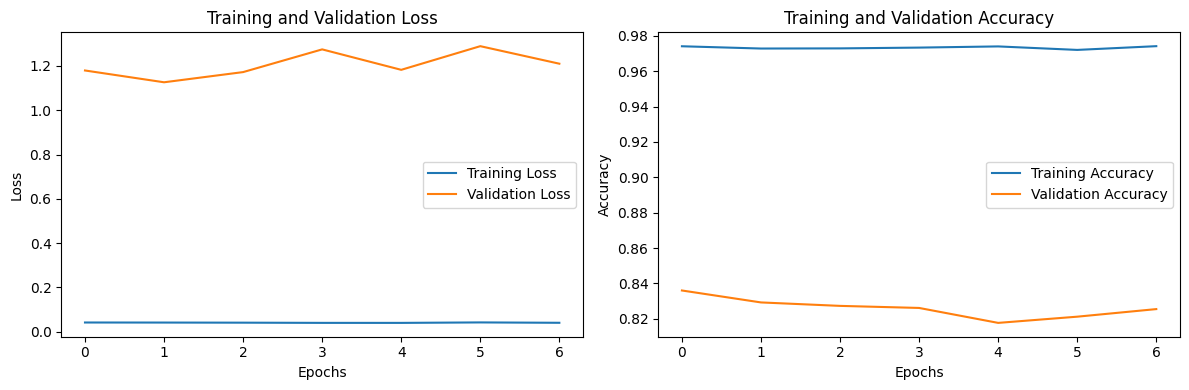

In [63]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
%load_ext tensorboard

# Define callback functions
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Create and compile the model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

num_classes = 8

# Convert integer target labels to one-hot encoding
y_one_hot = to_categorical(df['Category_enc'], num_classes)

# Use Tokenizer to convert text into word embedding sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Title'])
X_sequences = tokenizer.texts_to_sequences(df['Title'])

# Pad sequences to have the same length
max_sequence_length = 100  # Specify the maximum sequence length
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

# Build the TextCNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

embedding_dim = 100 

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Split the dataset, a typical ratio could be 70-15-15, or adjust as needed
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Retrain the model and apply callback functions
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stopping, tensorboard_cb])

# Load the best model
model.load_weights("best_model.h5")

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


### TensorBoard
Tensorboard is a tool allowing visualization of metrics logged during the training of a model. You can use it within colab (or jupyter) by loading the tensorboard extension:

In [76]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [77]:
%tensorboard --logdir my_logs

Reusing TensorBoard on port 6006 (pid 29570), started 0:00:39 ago. (Use '!kill 29570' to kill it.)

241/241 [==============================] - 0s 1ms/step


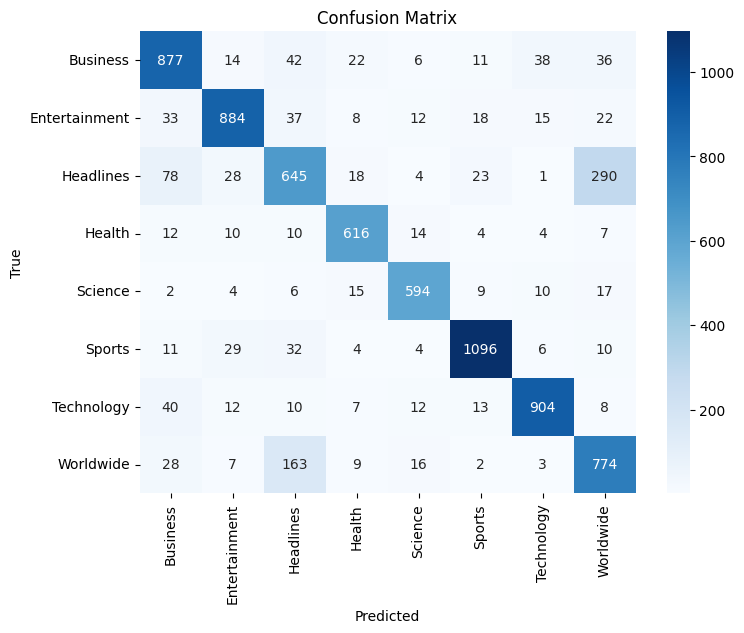

In [66]:
model.load_weights("best_model.h5")

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion = confusion_matrix(y_true_labels, y_pred_labels)

# Get the class labels from the 'Category' column of your DataFrame
class_labels = df['Category'].unique()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')  # X-axis label
plt.ylabel('True')  # Y-axis label
plt.title('Confusion Matrix')
plt.show()




So It is very difficult to identify the Headline and Worldwide, maybe il is not good to classify them.

Let's do some quick analysis

In [84]:
df.groupby('Category').value_counts()

Category   Title                                                                            Title_len  Category_enc
Business   stock today                                                                      11         0               5
           close price crude oil gold commod                                                33         0               5
           india adani group reject occrp report use opaqu fund invest                      59         0               4
           instacart upsiz ipo price deliv valu                                             36         0               3
           see privat jet sam bankmanfri ftx loan 28 million accord aviat firm              67         0               3
                                                                                                                      ..
Worldwide  north korea chang constitut declar nuclear state                                 48         7               1
           north korea celebr found d

In [87]:
specific_categories = ['Headlines']  
filtered_df = df[df['Category'].isin(specific_categories)]
counts = filtered_df['Category'].describe()
print(counts)


count          7155
unique            1
top       Headlines
freq           7155
Name: Category, dtype: object


In [95]:
category_avg_title_length = df.groupby('Category')['Title_len'].mean()

print(category_avg_title_length)

Category
Business         51.915147
Entertainment    56.947308
Headlines        55.056184
Health           50.809719
Science          52.191241
Sports           54.482164
Technology       49.563764
Worldwide        55.014601
Name: Title_len, dtype: float64


    That's make sense for the error, even human can not easyly identify the Headlines. I though il gonne be shorter than others.
    Thus the model is Good.